## K-means++

In this notebook, we are going to implement [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm with multiple initial sets. The original k-means++ algorithm will just sample one set of initial centroid points and iterate until the result converges. The only difference in this implementation is that we will sample `RUNS` sets of initial centroid points and update them in parallel. The procedure will finish when all centroid sets are converged.

In [2]:
### Definition of some global parameters.
K = 5  # Number of centroids
RUNS = 25  # Number of K-means runs that are executed in parallel. Equivalently, number of sets of initial points
RANDOM_SEED = 60295531
converge_dist = 0.1 # The K-means algorithm is terminated when the change in the location 
                    # of the centroids is smaller than 0.1

In [29]:
import numpy as np
import pickle
import sys
from numpy.linalg import norm
from matplotlib import pyplot as plt


def print_log(s):
    sys.stdout.write(s + "\n")
    sys.stdout.flush()


def parse_data(row):
    '''
    Parse each pandas row into a tuple of (station_name, feature_vec),
    where feature_vec is the concatenation of the projection vectors
    of TAVG, TRANGE, and SNWD.
    '''
    return (row[0],
            np.concatenate([row[1], row[2], row[3]]))


def compute_entropy(d):
    '''
    Compute the entropy given the frequency vector `d`
    '''
    d = np.array(d)
    d = 1.0 * d / d.sum()
    return -np.sum(d * np.log2(d))


def choice(p):
    '''
    Generates a random sample from [0, len(p)),
    where p[i] is the probability associated with i. 
    '''
    random = np.random.random()
    r = 0.0
    for idx in range(len(p)):
        r = r + p[idx]
        if r > random:
            return idx
    assert(False)


def kmeans_init(rdd, K, RUNS, seed):
    '''
    Select `RUNS` sets of initial points for `K`-means++
    '''
    # the `centers` variable is what we want to return
    n_data = rdd.count()
    shape = rdd.take(1)[0][1].shape[0]
    centers = np.zeros((RUNS, K, shape))

    def update_dist(vec, dist, k):
        new_dist = norm(vec - centers[:, k], axis=1)**2
        return np.min([dist, new_dist], axis=0)


    # The second element `dist` in the tuple below is the closest distance from
    # each data point to the selected points in the initial set, where `dist[i]`
    # is the closest distance to the points in the i-th initial set.
    data = rdd.map(lambda p: (p, [np.inf] * RUNS)) \
              .cache()

    # Collect the feature vectors of all data points beforehand, might be
    # useful in the following for-loop
    local_data = rdd.map(lambda (name, vec): vec).collect()

    # Randomly select the first point for every run of k-means++,
    # i.e. randomly select `RUNS` points and add it to the `centers` variable
    sample = [local_data[k] for k in np.random.randint(0, len(local_data), RUNS)]
    centers[:, 0] = sample

    for idx in range(K - 1):
        ##############################################################################
        # Insert your code here:
        ##############################################################################
        # In each iteration, you need to select one point for each set
        # of initial points (so select `RUNS` points in total).
        # For each data point x, let D_i(x) be the distance between x and
        # the nearest center that has already been added to the i-th set.
        # Choose a new data point for i-th set using a weighted probability
        # where point x is chosen with probability proportional to D_i(x)^2
        ##############################################################################
        
        #update distances.
        data = data.map(lambda (point, dist) : (point, update_dist(point[1], dist, idx))).cache()
        sum_dist = data.map(lambda (x, y): y).reduce(lambda x, y: x + y)
            
        prob = data.map(lambda (point, dist) : dist / sum_dist)
        prob_list = np.array(prob.collect())
        
        for i in range(25):
          centers[i, idx + 1] = local_data[choice(list(prob_list[:, i]))]

    return centers


def get_closest(p, centers):
    '''
    Return the indices the nearest centroids of `p`.
    `centers` contains sets of centroids, where `centers[i]` is
    the i-th set of centroids.
    '''
    best = [0] * len(centers)
    closest = [np.inf] * len(centers)
    for idx in range(len(centers)):
        for j in range(len(centers[0])):
            temp_dist = norm(p - centers[idx][j])
            if temp_dist < closest[idx]:
                closest[idx] = temp_dist
                best[idx] = j
    return best


def kmeans(rdd, K, RUNS, converge_dist, seed):
    '''
    Run K-means++ algorithm on `rdd`, where `RUNS` is the number of
    initial sets to use.
    '''
    k_points = kmeans_init(rdd, K, RUNS, seed)
    print k_points
    print_log("Initialized.")
    temp_dist = 1.0

    iters = 0
    st = time.time()
    #closest = rdd.flatMap(lambda p: (p[1], list(enumerate(get_closest(p[1], k_points)))))
    
    while temp_dist > converge_dist:
        closest = rdd.map(lambda p: (p[1], get_closest(p[1], k_points)))
        nearest_points = closest.flatMap(lambda (p, nearest): [((idx, nearest[idx]), (p, 1)) 
                                                              for idx in range(len(nearest))])
        avg_points = nearest_points.reduceByKey(lambda x, y : (x[0] + y[0], x[1] + y[1]))
        new_points = avg_points.map(lambda (key, point) : (key, point[0] / point[1])).collectAsMap()
        
        ##############################################################################
        # INSERT YOUR CODE HERE
        ##############################################################################
        
        # Update all `RUNS` sets of centroids using standard k-means algorithm
        # Outline:
        #   - For each point x, select its nearest centroid in i-th centroids set
        #   - Average all points that are assigned to the same centroid
        #   - Update the centroid with the average of all points that are assigned to it
        
        # Insert your code here

        # You can modify this statement as long as `temp_dist` equals to
        # max( sum( l2_norm of the movement of j-th centroid in each centroids set ))
        ##############################################################################

        temp_dist = np.max([
                np.sum([norm(k_points[idx][j] - new_points[(idx, j)]) for j in range(K)])
                    for idx in range(RUNS)])

        iters = iters + 1
        if iters % 5 == 0:
            print_log("Iteration %d max shift: %.2f (time: %.2f)" %
                      (iters, temp_dist, time.time() - st))
            st = time.time()

        # update old centroids
        # You modify this for-loop to meet your need
        for ((idx, j), p) in new_points.items():
            k_points[idx][j] = p

    return k_points

In [4]:
## Read data
data = pickle.load(open("../../Data/Weather/stations_projections.pickle", "rb"))
rdd = sc.parallelize([parse_data(row[1]) for row in data.iterrows()])
rdd.take(1)

[(u'USC00044534', array([  3.04796236e+03,   1.97434852e+03,   1.50560792e+02,
          -2.90363288e+03,  -2.36907268e+02,   1.47021791e+02,
           1.91503001e-01,   1.87262808e-01,  -4.01379553e-02]))]

In [30]:
# main code

import time

st = time.time()

np.random.seed(RANDOM_SEED)
centroids = kmeans(rdd, K, RUNS, converge_dist, np.random.randint(1000))
group = rdd.mapValues(lambda p: get_closest(p, centroids)) \
           .collect()

print "Time takes to converge:", time.time() - st

[[[  2.23643114e+03   1.95170147e+03  -3.61944620e+01 ...,   6.34745555e+01
     2.10312468e+01  -2.76628330e+00]
  [  1.00620820e+03   1.51910127e+03   1.02186191e+02 ...,   7.31306416e+03
    -7.29344006e+01   2.39440682e+01]
  [  2.12907689e+03   1.39902211e+03   1.12658115e+02 ...,   6.49062252e+00
     2.78814746e+00   2.94524554e+00]
  [  3.79211741e+02   2.41464461e+03   9.62494430e+01 ...,   1.77513598e+03
     2.45685554e+02   7.41967778e+01]
  [  4.77407578e+02   1.24797600e+03   1.04493669e+02 ...,   2.39277044e+04
    -6.89845024e+03   2.42998018e+03]]

 [[  1.77917284e+03   2.29614419e+03   7.52235567e+01 ...,   3.25299356e+02
     1.05755495e+02   9.68318817e+01]
  [  3.59619977e+02   1.49067642e+03   9.41540149e+01 ...,   2.21878818e+04
    -6.72839268e+03   2.75422121e+03]
  [  2.42231008e+01   1.52235303e+03   8.58670182e+01 ...,   6.69992722e+03
    -1.62178959e+03   3.44832044e+02]
  [  4.09498140e+03   1.83404463e+03   8.47543231e+01 ...,   0.00000000e+00
     0.000

KeyboardInterrupt: 

## Verify your results
Verify your results by computing the objective function of the k-means clustering problem.

In [23]:
def get_cost(rdd, centers):
    '''
    Compute the square of l2 norm from each data point in `rdd`
    to the centroids in `centers`
    '''
    def _get_cost(p, centers):
        best = [0] * len(centers)
        closest = [np.inf] * len(centers)
        for idx in range(len(centers)):
            for j in range(len(centers[0])):
                temp_dist = norm(p - centers[idx][j])
                if temp_dist < closest[idx]:
                    closest[idx] = temp_dist
                    best[idx] = j
        return np.array(closest)**2
    
    cost = rdd.map(lambda (name, v): _get_cost(v, centroids)).collect()
    return np.array(cost).sum(axis=0)

cost = get_cost(rdd, centroids)

In [24]:
log2 = np.log2

print log2(np.max(cost)), log2(np.min(cost)), log2(np.mean(cost))

33.8254902123 33.7575332525 33.7790236109


## Plot the increase of entropy after multiple runs of k-means++

In [25]:
entropy = []

for i in range(RUNS):
    count = {}
    for g, sig in group:
        _s = ','.join(map(str, sig[:(i + 1)]))
        count[_s] = count.get(_s, 0) + 1
    entropy.append(compute_entropy(count.values()))

**Note:** Remove this cell before submitting to PyBolt (PyBolt does not fully support matplotlib)

4.8799771938634473

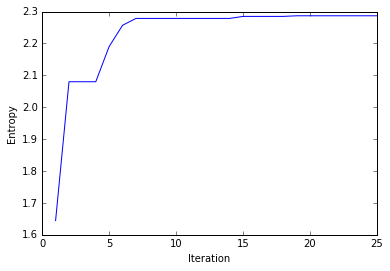

In [26]:
%matplotlib inline

plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.plot(range(1, RUNS + 1), entropy)
2**entropy[-1]

## Print the final results

In [10]:
print 'entropy=',entropy
best = np.argmin(cost)
print 'best_centers=',list(centroids[best])

entropy= [1.3905741806487766, 1.3968259987382798, 1.4290099071953895, 1.4290099071953897, 1.4290099071953897, 1.4290099071953897, 1.4295136162503568, 2.1561475440342912, 2.779439680581588, 2.779439680581588, 2.779439680581588, 2.779439680581588, 2.779439680581588, 2.779439680581588, 2.779439680581588, 2.779439680581588, 2.7794396805815875, 2.779439680581588, 2.7794396805815884, 2.7794396805815875, 2.779439680581588, 2.7794396805815884, 2.779439680581588, 2.7794396805815884, 2.779439680581588]
best_centers= [array([  755.60040185,  2014.45011665,  -145.56245747, -1801.94735183,
        -117.5745423 ,   330.90658173,  4042.34130993,  -141.91904124,
         307.23457173]), array([ 1619.79633657,  1811.03082542,   151.59467421, -3270.67490428,
        -367.45062501,    65.25042025,    28.02149815,    19.22235773,
          13.44587806]), array([ 3577.71110614,  2658.33530741,   367.60120045, -2457.74663993,
        -346.08945757,   189.80261947,     0.        ,     0.        ,
           